In [1]:
# All required libraries and functions  are imported in this cell
from __future__ import division     # Enable floating point division 
from IPython.utils import io        # Suppress undesired print commands  
import os as os                     # Operating system funcitons for navigation pursposes
import numpy as np                  # Numerical Library for matrix operations
import numpy.random as npr
import matplotlib.pyplot as plt     # Plotting Library 
import scipy.optimize as spo
import scipy.io as sio
import scipy.misc as scm
import warnings as iw
import operator                     # Utility for sorting index of value in array

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Sharp plots  

data_dir="C:/GitHub/ML_Coursera/ex4/data/"

##  A: Supporting functions

###### Collection of supporting functions that are provided in the exercise


In [2]:
# Define hypothesis function for logistic regression
def lg_hyp(X,theta):
    z = np.matmul(X,theta)
    return 1/(1+np.exp(-z))

def sigmoid(z):
    return 1/(1+np.e**(-z))

## B: Utility functions 

###### Data retival and plot configuration functions

In [3]:
# Return the contents of the data file
def load_data(data_dir,f_name):                       
    os.chdir(data_dir)
    data=sio.loadmat(f_name)
    return data

## 1 Neural Networks

## 1.1 Visualizing the data

In [4]:
data=load_data(data_dir,'ex4data1.mat')             # sio.loadmat returns a dictionary
print data.keys()

['y', 'X', '__version__', '__header__', '__globals__']


In [5]:
X=data['X']
y=data['y']     #  y tells us the value for the training example [1:9]-->[1:9],0-->10
print X.shape,y.shape

(5000L, 400L) (5000L, 1L)


In [6]:
# Restructure unrolled data of grayscale intensity 
def select_data(X,idx):
    row, col = 20, 20         # unroll: 400 = [20, 20]
    px_data  = X[idx]         # select an example 
    
    #  Generate matrix of normalized values
    px_mat   = (px_data/max(px_data)).reshape((row, col))*255    
    return px_mat.T           # Make the image vertical 

In [7]:
def displayData(X):
    rand=((X.shape[0]*npr.random(100)).astype(int)).reshape(10,10)  # Generate a 10,10 grid of random numbers [0,5000)
    pic=np.zeros((200,200))
    for i in range(10):
        for j in range(10):
            mat_a=select_data(X,rand[i][j])
            pic[20*i:20*(i+1),20*j:20*(j+1)]=mat_a    # big_mat[row_range,col_range]=small_mat
    return scm.toimage(pic)                              # 'L' for Grey Scale 

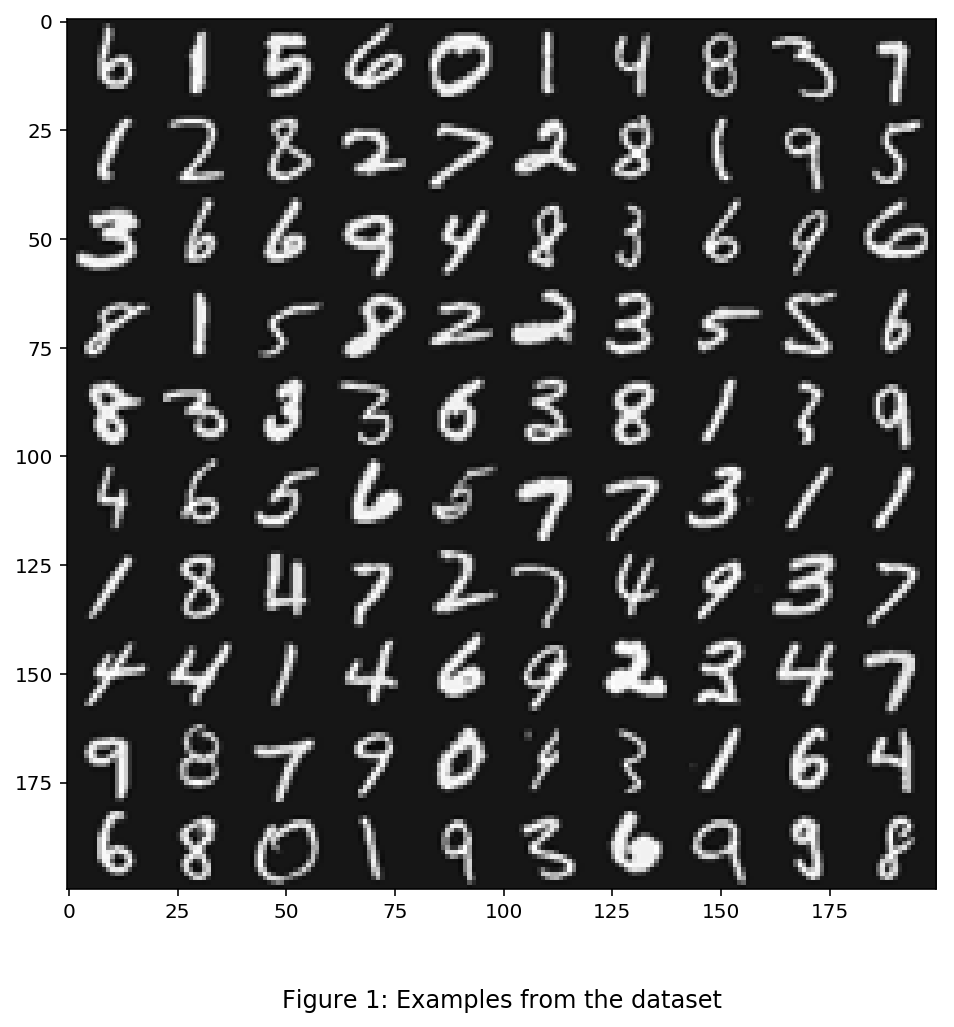

In [8]:
img=displayData(X)
#Lets plot the image
plt.figure(figsize=(8,8))
plt.title('Figure 1: Examples from the dataset',y=-0.15)
plt.imshow(img,cmap='gray')

## 1.2 Model representation

In [9]:
data_nn=load_data(data_dir,'ex4weights.mat')             # sio.loadmat returns a dictionary
print data_nn.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']


In [10]:
THETA =[data_nn['Theta1'],data_nn['Theta2']]
print THETA[0].shape, THETA[1].shape

(25L, 401L) (10L, 26L)


In [11]:
# input shape for layers
L=3                        # Number of layers

# Neural units in each layer without bias unit
nu_L1=400                  # Input layer 
nu_L2=25                   # Hidden layer 
nu_L3=10                   # Output layer 

In [12]:
K=10                       # Neural units in output layer         
m=X.shape[0]               # Number of training examplesb

In [13]:
print THETA[0][:,1]

[ -1.05624163e-08   7.66168682e-09  -8.77654466e-09  -6.31835805e-09
   8.14776724e-09  -7.76628103e-09  -6.38021750e-09   8.05170531e-09
   5.88120074e-10  -8.93864625e-09  -9.72549575e-09  -4.88182536e-09
  -1.58217927e-09   1.04479599e-08  -9.69310074e-09  -8.95204241e-09
  -9.72618005e-09   6.79302157e-09  -5.96869327e-09  -5.66060774e-09
   4.75278517e-09  -2.09991386e-09  -8.89272060e-09   3.05178374e-10
   8.85876862e-09]


## 1.3, 1.4 Feedforward and cost function with regularization

In [14]:
def flatten_THETA(THETA, flag=0):             # flag=0 flatten theta for operation 
    tf=[]                                     # flag=1 flatten theta[:,1:] for regularization
    if flag==0:
        for i in np.arange(L-1):
            tf+=list(THETA[i].flatten())
    if flag==1: 
        for i in np.arange(L-1):
            tf+=list(THETA[i][:,1:].flatten())
    tf=np.array(tf)
    tf=np.array(tf).flatten()
    return tf

def reshape_THETA(flatTHETA):
    global L 
    THETA=list(np.ones(L-1))
    THETA[0]=flatTHETA[:401*25].reshape((25,401))
    THETA[1]=flatTHETA[401*25:].reshape((10,26))
    return THETA

#### Test flatten_THETA and reshape_THETA

In [48]:
ft=flatten_THETA(THETA, flag=0)
print ft.shape      # Expected Shape= 25*401+10*26 =10285

tf=reshape_THETA(ft)
print tf[0].shape,tf[1].shape

ft1=flatten_THETA(THETA,flag=0)
print ft.shape
ft==ft1

(10285L,)
(25L, 401L) (10L, 26L)
(10285L,)


array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [16]:
print np.unique(y)

[ 1  2  3  4  5  6  7  8  9 10]


In [17]:
'''
0 is marked as 10 in y.
The nerual network outputs zero at its last node
The onHotEncoding for 0 will be [0......0 1]
'''
def oneHotEncoder(y):        # Generate vecotors of form [1 0 0 ...]
    y_mat=np.zeros((5000,10))
    for i in np.arange(len(y)):
        j=y[i]-1
        y_mat[i][j]=1
    return y_mat

In [18]:
y_mat=oneHotEncoder(y)

In [19]:
# Using sigmoid function here instead of lg_hyp so I could have z values explicitly 
def feedForwardPropagation(a,THETA):
    a1=np.insert(a,0,1)
    z2=np.matmul(THETA[0],a1)
    
    a2=sigmoid(z2)
    a2=np.insert(a2,0,1)
    
    z3=np.matmul(THETA[1],a2)
    a3=sigmoid(z3)
    
    A=[a1,a2,a3]
    Z=[z2,z3]
        
    return A,Z

In [20]:
A,Z=feedForwardPropagation(a=X[1],THETA=THETA)
print A[-1]

[  4.79026796e-04   2.41495958e-03   3.44755685e-03   4.05616281e-05
   6.53412433e-03   1.75930169e-03   1.15788527e-02   2.39107046e-03
   1.97025086e-03   9.95696931e-01]


In [21]:
def ffd_loop(X,THETA):
    yp_mat=np.zeros((m,K))
    for i in np.arange(m):
        yp_arr,Z  = feedForwardPropagation(a=X[i], THETA=THETA)    # Hypothesis Array
        yp_mat[i] = yp_arr[-1]                                      # Predicted values: last activation function
    return yp_mat        

In [22]:
yp_mat = ffd_loop(X,THETA)

#### nnCostFunction-----------------------------------------------------------------------------------------------------------------------------

In [23]:
def nnCostFunction(X,y_mat,THETA_flat,lambdA):
    THETA=reshape_THETA(THETA_flat)
    
    # Generate the probability values using forward propagation 
    yp_mat = ffd_loop(X,THETA)          
    
    # Flatten 2D-matrices
    H      = yp_mat.flatten()
    yf     = y_mat.flatten()
    tf     = flatten_THETA(THETA=THETA,flag=0)
    
    # Compute cost function terms
    t1     = -yf.dot((np.log(H)).T)/m
    t2     = -(1-yf).dot((np.log(1-H)).T)/m
    t3_reg = tf.dot(tf.T)*lambdA/(2*m)
    return t1+t2+t3_reg

#### nnCostFunction w/ lambda=0

In [24]:
print'Computed Cost for Neural Network :', nnCostFunction(X=X,y_mat=y_mat, THETA_flat=flatten_THETA(THETA), lambdA=0),'\n', \
      'Estimated Cost for Neural Network: 0.287629 ' 

Computed Cost for Neural Network : 0.287629165161 
Estimated Cost for Neural Network: 0.287629 


#### nnCostFunction w/  lambda=1

In [25]:
print'Computed Cost for Neural Network with lambda=1 :', nnCostFunction(X=X,y_mat=y_mat, THETA_flat=flatten_THETA(THETA), lambdA=1),'\n', \
      'Estimated Cost for Neural Network with lambda=1: 0.383770 ' 

Computed Cost for Neural Network with lambda=1 : 0.384487796243 
Estimated Cost for Neural Network with lambda=1: 0.383770 


 ## 2 Backpropagation

## 2.1 Sigmoid gradient

#### sigmoidGradient----------------------------------------------------------------------------------------------------------------------------

In [26]:
def sigmoidGradient(z):
    gz=1/(1+np.e**(-z))
    return np.multiply(gz,(1-gz))

In [27]:
sigmoidGradient(0)

0.25

## 2.2 Random initialization

In [28]:
def randInitializeWeights(NU=[nu_L1,nu_L2,nu_L3]):
    global L
    THETA=list(np.ones(L-1))                           # Number of theta Matrices
    
    epsilon_init=0.12                                  
    for i in np.arange(L-1):
        wt = npr.random(([NU[i+1],NU[i]+1]))*2*epsilon_init-epsilon_init  # Thumb rule for intialization    
        THETA[i]=wt
    return THETA     

In [29]:
THETA=randInitializeWeights()
# Check Dimensions
print "Theta for the input layer 1: " , THETA[0].shape,"\n", "THETA[0] samples:", "\n" ,THETA[0][:5,:5], "\n\n", \
      "Theta for the input layer 2: " , THETA[1].shape,"\n", "THETA[1] samples:", "\n" ,THETA[1][:5:,:5]                    

Theta for the input layer 1:  (25L, 401L) 
THETA[0] samples: 
[[ 0.08866103  0.05287507  0.07664992  0.04442609  0.07846026]
 [ 0.00392618  0.06995183 -0.06154289 -0.06888854 -0.10697748]
 [ 0.11384859  0.11194115 -0.11918648 -0.05112735  0.10360327]
 [ 0.08405143 -0.0998848  -0.08676486 -0.03849888  0.02405707]
 [-0.0847542   0.0089568   0.11254526 -0.00540638 -0.02452292]] 

Theta for the input layer 2:  (10L, 26L) 
THETA[1] samples: 
[[-0.02388786 -0.02533019  0.01091904 -0.04486811 -0.01775288]
 [ 0.10985418 -0.10845179  0.04069774  0.1143796  -0.06273356]
 [ 0.05899914  0.09092567  0.07660626 -0.03259596 -0.11384947]
 [ 0.02584681  0.11640853 -0.07803129  0.07968146  0.10584756]
 [-0.05320647  0.04788599  0.01839865 -0.1158644  -0.0748233 ]]


In [30]:
## 2.3 Backpropagation

In [31]:
print y_mat[0].shape,THETA[1].shape,THETA[0].shape

(10L,) (10L, 26L) (25L, 401L)


In [32]:
print A[0].shape, A[1].shape, A[2].shape
print Z[0].shape, Z[1].shape

(401L,) (26L,) (10L,)
(25L,) (10L,)


In [45]:
def backPropagation(X,THETA_flat,y_mat,lambdA=0):
    THETA=reshape_THETA(THETA_flat)
    
    D2=np.zeros(THETA[1].shape)               
    D1=np.zeros(THETA[0].shape)
    #print D2.shape,D1.shape
    for i in np.arange(m):
        # Step 1
        a=X[i]                                   # Set a=x[i]
        
        A,Z=feedForwardPropagation(a, THETA)     # Perform forward propagation
        
        # It is possible to loop and minimize lines of code but it resulted in me tracking too many things hence I have simplified it        
        
        a1=A[0].reshape((A[0].shape[0],1))                 # covert into 2D arrays           
        a2=A[1].reshape((A[1].shape[0],1))
        a3=A[2].reshape((A[2].shape[0],1))
        
        z2=Z[0].reshape((Z[0].shape[0],1))
        z3=Z[1].reshape((Z[1].shape[0],1))
        
        th1=THETA[0]
        th2=THETA[1]
        
        yi=y_mat[i].reshape((y_mat[i].shape[0],1))
        

        if i==1:print a3.shape, a2.shape, a1.shape, z3.shape, z2.shape
        
        # Step 2  :Layer 3
        d3=(a3-yi)                     # d3 = 10 x 1
       
        # Step 3  :Layer 2
        d2=np.multiply( np.matmul(th2[:,1:].T,d3), sigmoidGradient(z2)  )
        if i==1:print d3.shape, d2.shape, i
        #print np.matmul(d3,a2.T).shape,d2.dot(a1.T).shape
        
        # Step 4
        d3.dot(a2.T)[:,1:].shape
        D2[:,1:]+=D2[:,1:]+d3.dot(a2.T)[:,1:]
        D1[:,1:]+=D1[:,1:]+d2.dot(a1.T)[:,1:]
        
    # Step /5
    J2 = D2.flatten()/m
    J1 = D1.flatten()/m
    Jp=np.array(list(J1)+list(J2))
    print len(Jp)
    return Jp

In [46]:
fprime = backPropagation(X,THETA_flat=flatten_THETA(THETA,flag=0),y_mat=y_mat)

(10L, 1L) (26L, 1L) (401L, 1L) (10L, 1L) (25L, 1L)
(10L, 1L) (25L, 1L) 1


C:\Users\Parag Rane\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: overflow encountered in add
C:\Users\Parag Rane\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:41: RuntimeWarning: overflow encountered in add


10285


## 2.4 Gradient Checking

In [ ]:
def computeNumericalGradient(THETA):
    flat_THETA=
def checkNNGradients()

In [ ]:
# Using sigmoid function here instead of lg_hyp so I could have z values explicitly 
def feedForwardPropagation(a,THETA):
    A=list(np.ones(L-1))            # We do not need to store the first activation
    Z=list(np.ones(L-1))
    for i in np.arange(L-1):
   
        a=np.insert(a,0,1)          # Add bias unit       
        z=np.matmul(THETA[i],a)     # Compute z
        a=sigmoid(z)                # Compute activaiton function

        Z[i]=z                      # Store z
        A[i]=a                      # Store activation functions without bias units
        
    return A,Z